Importing Packages for SQLite

In [6]:
import os
import glob
import sqlite3
import pandas as pd

directory = 'Users/student/Documents/GitHub/Higher-Education-Analysis/Data'

# Connect to a new SQLite database
with sqlite3.connect('hesa.db') as conn:
    # Iterate through all CSV files in the directory
    for csv_file in glob.glob(os.path.join(directory, '*.csv')):
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(csv_file)
        # Get the base name of the CSV file without the file extension
        table_name = os.path.splitext(os.path.basename(csv_file))[0]
        # Write the DataFrame to a new table in the SQLite database
        df.to_sql(table_name, conn, index=False, if_exists="replace")

        # Get a cursor to the database
        cursor = conn.cursor()

        # Get the names of all tables
        cursor.execute("""SELECT name FROM sqlite_master WHERE type='table';""")
        table_names = cursor.fetchall()

        # Iterate through all tables and print an overview of their columns
        for table_name in table_names:
            table_name = table_name[0]
            cursor.execute(f"PRAGMA table_info({table_name});")
            print(f'Table: {table_name}')
            print('-'*20)
            columns = cursor.fetchall()
            for column in columns:
                print(f"Name: {column[1]}, Type: {column[2]}")
            print("\n")

        # Iterate through all tables and drop columns with 'URL' in their name
        for table_name in table_names:
            table_name = table_name[0]
            cursor.execute(f"PRAGMA table_info({table_name});")
            columns = cursor.fetchall()
            for column in columns:
                if 'URL' in column[1]:
                    cursor.execute(f"ALTER TABLE {table_name} DROP COLUMN {column[1]};")
                    print(f"Dropped column {column[1]} from table {table_name}")

        # Commit the changes
        conn.commit()

        # Close the cursor
        cursor.close()

        # Write the DataFrame to a SQLite table
        with sqlite3.connect("HESA_Data.db") as conn:
            df.to_sql("dt051-table-59", conn, if_exists="replace")


In [10]:
# Read the CSV file
df = pd.read_csv("/Users/student/Documents/GitHub/Higher-Education-Analysis/Data/dt051-table-59.csv", on_bad_lines='skip')


### Looking over data

### Looking at created data in Pandas

4            Aecc University College
289      The University of Lancaster
496    University Academy 92 Limited
Name: LEGAL_NAME, dtype: object


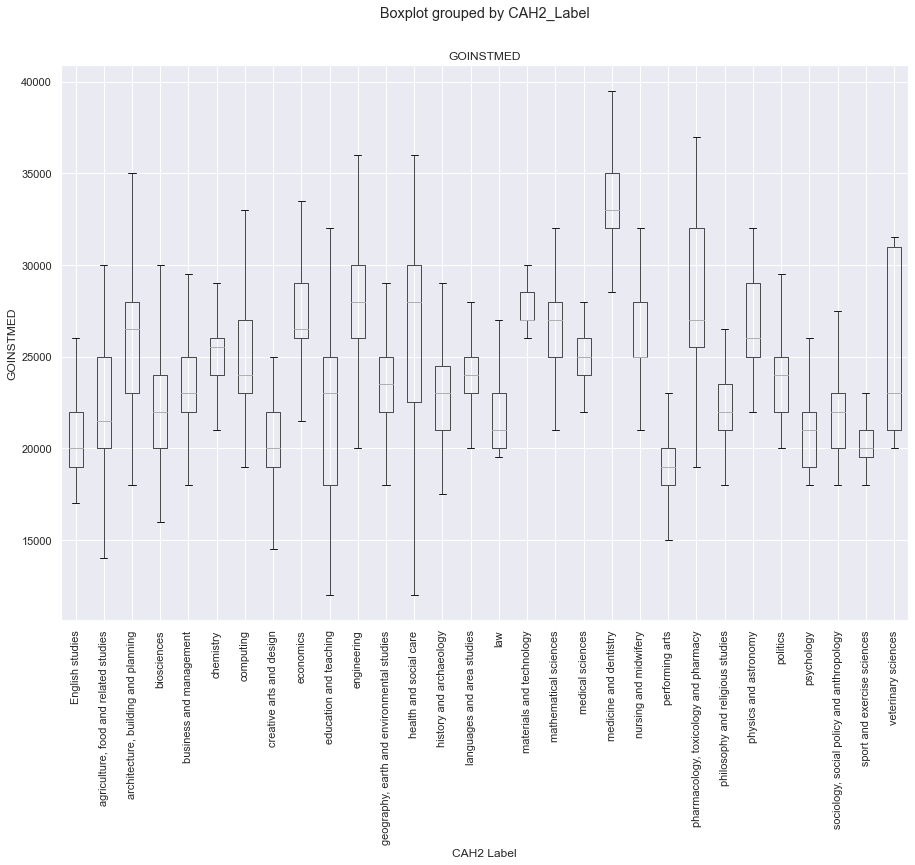

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read CSV files
institution = pd.read_csv('/Users/student/Documents/GitHub/Higher-Education-Analysis/Data/INSTITUTION.csv')[['LEGAL_NAME','PROVADDRESS','UKPRN','PUBUKPRN']]
go_salary = pd.read_csv('/Users/student/Documents/GitHub/Higher-Education-Analysis/Data/GOSALARY.csv').sort_values(by='GOINSTMED').dropna(subset=['GOINSTMED'])
employment = pd.read_csv('/Users/student/Documents/GitHub/Higher-Education-Analysis/Data/EMPLOYMENT.csv').sort_values(by='UNEMP')
nss = pd.read_csv('/Users/student/Documents/GitHub/Higher-Education-Analysis/Data/NSS.csv')
cah = pd.read_csv('/Users/student/Downloads/CAH_Groupings.csv')[['CAH2_Code', 'CAH2_Label']]

# Data processing
top_10_ukprn = employment.head(10)['UKPRN']
institution_name = institution.loc[institution['UKPRN'].isin(top_10_ukprn), 'LEGAL_NAME']
print(institution_name)

go_salary = go_salary[['PUBUKPRN', 'UKPRN', 'KISCOURSEID', 'KISMODE', 'GOSALSBJ', 'GOINSTLQ', 'GOINSTMED', 'GOINSTUQ']]
sal_inst = pd.merge(go_salary, institution, on='UKPRN', how='inner')

nss = nss[nss['Q1'].notna()].drop(columns=['NSSUNAVAILREASON', 'NSSPOP', 'NSSRESP_RATE', 'NSSAGG','NSSSBJ'])
sal_inst_nss = pd.merge(sal_inst, nss, on='KISCOURSEID', how='inner').drop(columns=['PUBUKPRN_x', 'UKPRN_x', 'KISMODE_x', 'PUBUKPRN_y', 'UKPRN_y', 'KISMODE_y'])
sal_inst_nss["GOSALSBJ"] = sal_inst_nss["GOSALSBJ"].apply(lambda x: x[:8])

merged_df = pd.merge(sal_inst_nss, cah, left_on='GOSALSBJ', right_on='CAH2_Code')

# Visualization
sns.set(rc={'figure.figsize':(14.7,10.27)})

to_drop = ['allied health', 'media, journalism and communications', 'Celtic studies', 'general, applied and forensic sciences', 'combined and general studies']
filtered_m_df2 = merged_df[~merged_df['CAH2_Label'].isin(to_drop)].reset_index(drop=True)

fig, ax = plt.subplots()
filtered_m_df2.boxplot(column='GOINSTMED', by='CAH2_Label', ax=ax, showfliers=False)
ax.set_xlabel('CAH2 Label')
ax.set_ylabel('GOINSTMED')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()


merged_df.to_csv('Tableau_Public_HESA1.csv')


205


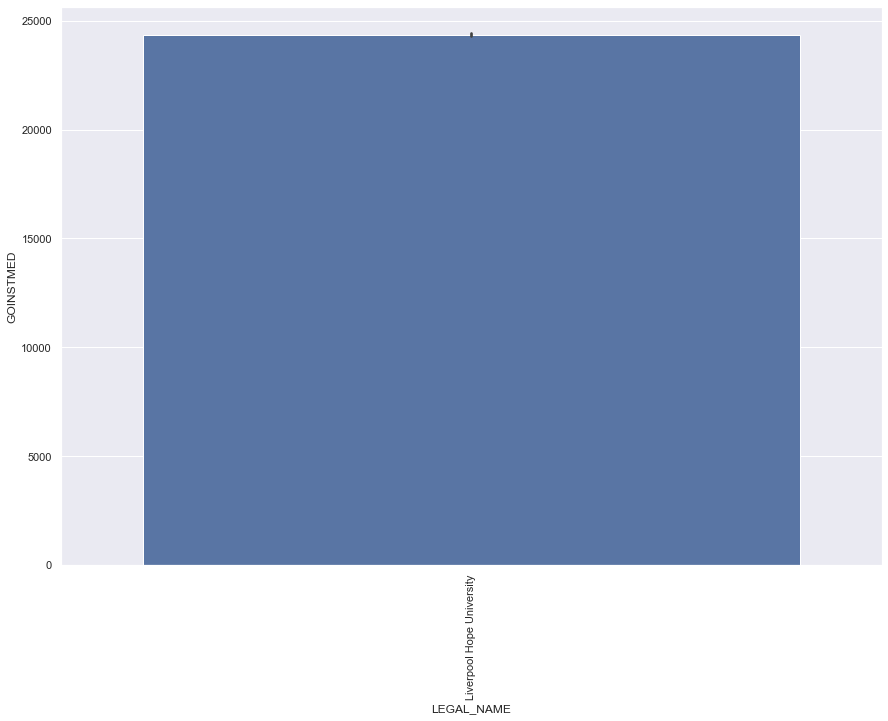

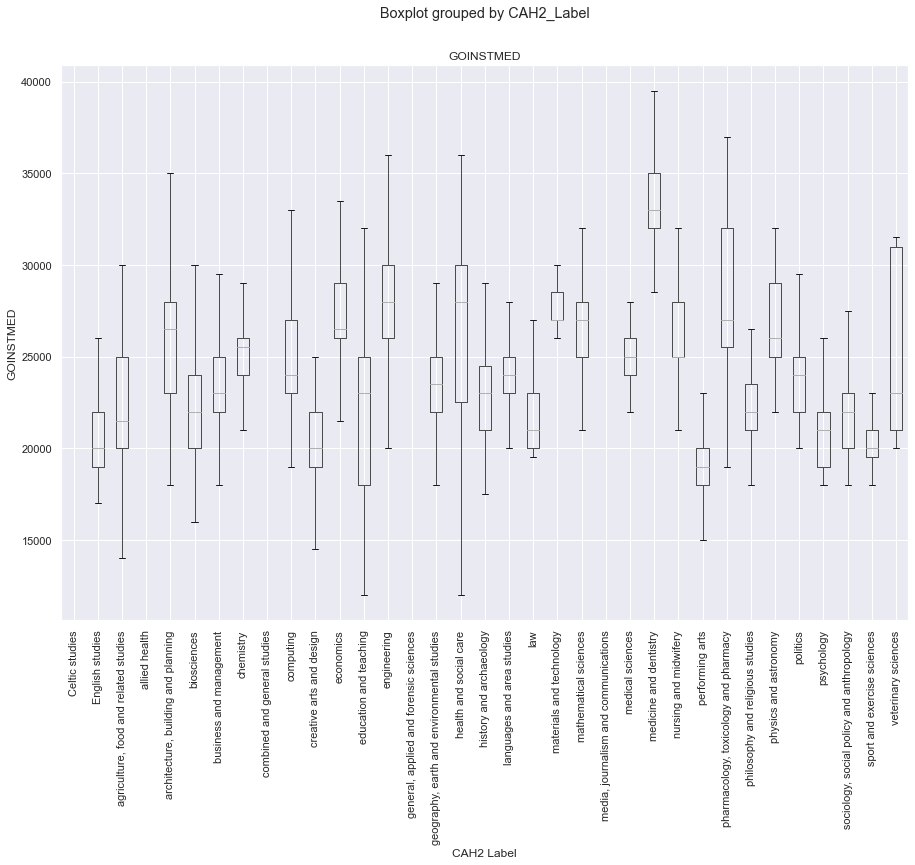

,LEGAL_NAME,GOINSTLQ,GOINSTMED,GOINSTUQ
245,University College of Estate Management,34000.0,40000.0,50000.0
99,Hull York Medical School,30000.0,35000.0,38000.0
23,Birkbeck College,24000.0,35000.0,42000.0
102,"Imperial College of Science, Technology and Medicine",30000.0,33000.0,41500.0
204,The London Institute of Banking & Finance,28000.0,32000.0,37500.0
38,Brighton and Sussex Medical School,28000.0,32000.0,36000.0
205,The London School of Economics and Political Science,25000.0,31500.0,45000.0
6,Aecc University College,27000.0,30000.0,40000.0
211,The University of Bath,27500.0,30000.0,33000.0
207,The Open University,24000.0,30000.0,39000.0


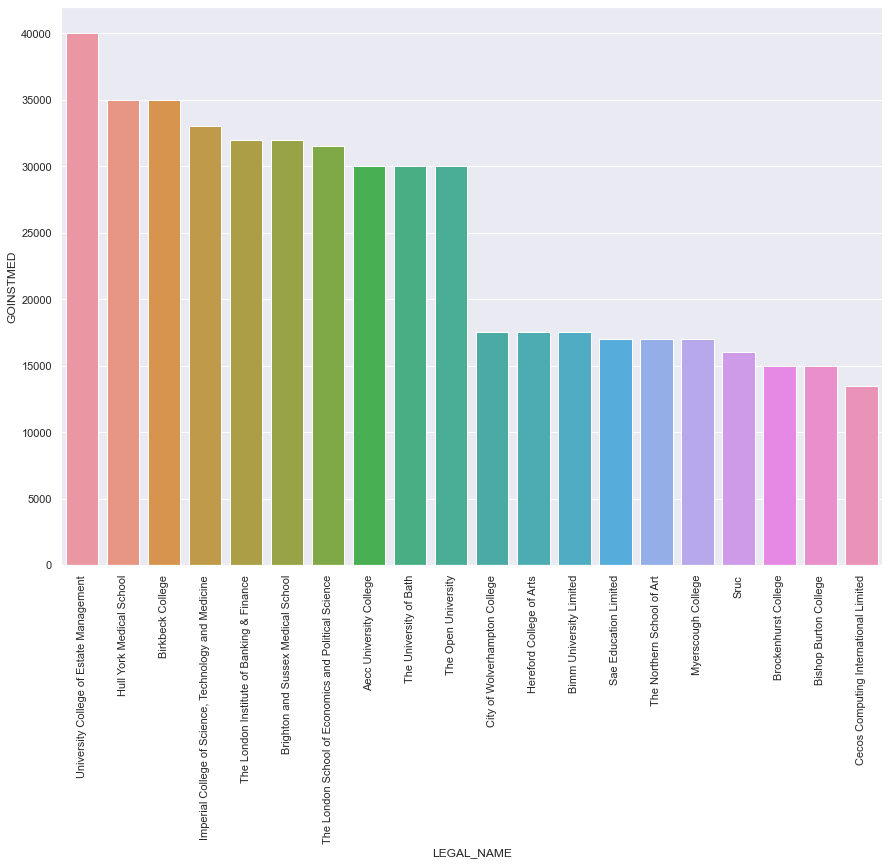

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already created the merged_df DataFrame

# Filter for 'computing' in CAH2_Label
merged_df_computing = merged_df.loc[merged_df['CAH2_Label'] == 'computing']

# Print unique answers
unique_answers = merged_df_computing['LEGAL_NAME'].unique()
num_unique_answers = len(unique_answers)
print(num_unique_answers)

# Plot barplot for first 650 rows
mfcu = merged_df_computing.head(650)
ax4 = sns.barplot(x='LEGAL_NAME', y='GOINSTMED', data=mfcu)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)

# Group by CAH2_Label and calculate the median
grouped1 = merged_df.groupby('CAH2_Label').median()
grouped1 = grouped1.reset_index()

# Set figure size
sns.set(rc={'figure.figsize': (14.7, 10.27)})

# Filter unwanted labels
to_drop = ['allied health', 'media, journalism and communications', 'Celtic studies', 'general, applied and forensic sciences', 'combined and general studies']
filtered_m_df2 = merged_df[~merged_df['CAH2_Label'].isin(to_drop)].reset_index(drop=True)

# Create boxplot
fig, ax = plt.subplots()
filtered_m_df2.boxplot(column='GOINSTMED', by='CAH2_Label', ax=ax, showfliers=False)
ax.set_xlabel('CAH2 Label')
ax.set_ylabel('GOINSTMED')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

# Convert 'CAH2_Label' to categorical
merged_df['CAH2_Label'] = pd.Categorical(merged_df['CAH2_Label'])

#Creating the SAL_INST_NSS DataFrame
SAL_INST_NSS = pd.merge(sal_inst, nss, on='KISCOURSEID', how='inner')
ECON = SAL_INST_NSS[["GOSALSBJ"]]

# Filter for 'CAH15-02' in CAH2_Code
ECON1 = merged_df[merged_df["CAH2_Code"] == "CAH15-02"]

# Group by 'LEGAL_NAME' and calculate the median
Inst_Sal = merged_df.groupby('LEGAL_NAME').median().reset_index().sort_values('GOINSTMED', ascending=False)

# Combine top 10 and bottom 10 institutions
top_10 = Inst_Sal.head(10)
bottom_10 = Inst_Sal.tail(10)
combined_df = pd.concat([top_10, bottom_10])

# Create a DataFrame with specific columns
cdf = combined_df[['LEGAL_NAME', 'GOINSTLQ', 'GOINSTMED', 'GOINSTUQ']]

# Display the DataFrame as HTML
from IPython.display import display, HTML
display(HTML(cdf.to_html()))

# Plot barplot for combined_df
ax2 = sns.barplot(x='LEGAL_NAME', y='GOINSTMED', data=combined_df)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

# Save merged_df to a CSV file
merged_df.to_csv('Tableau_Public_HESA1.csv')


In [12]:
merged_df_computing = merged_df.loc[merged_df['CAH2_Label'] == 'computing']
unique_answers = merged_df_computing['LEGAL_NAME'].unique()
num_unique_answers = len(unique_answers)
print(num_unique_answers)

205


[Text(0, 0, 'Liverpool Hope University')]

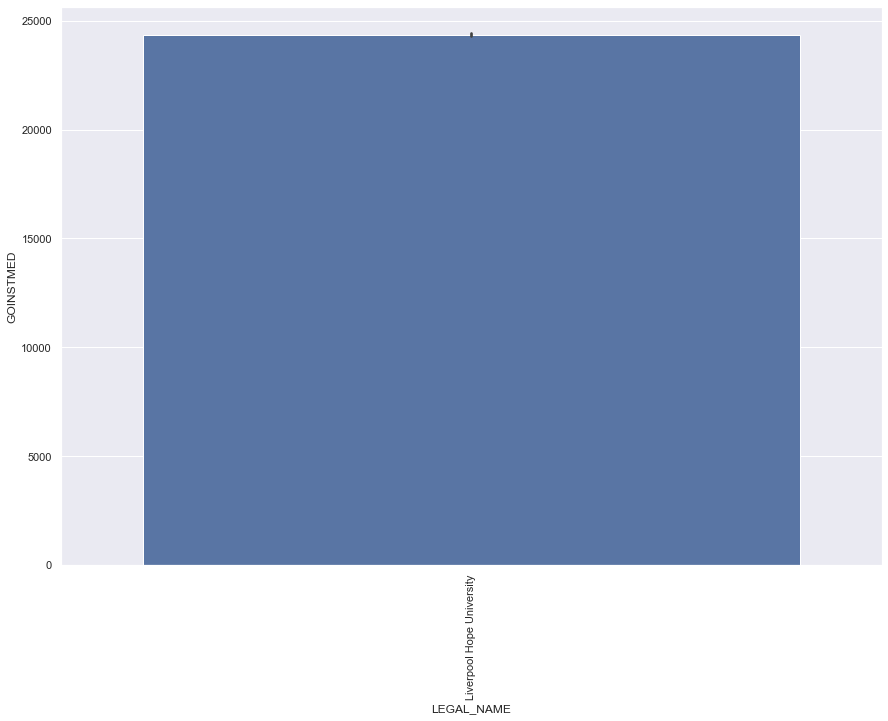

In [13]:
import seaborn as sns
mfcu=merged_df_computing.head(650)
ax4 = sns.barplot(x='LEGAL_NAME', y='GOINSTMED', data=mfcu)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)

In [14]:
grouped1 = merged_df.groupby('CAH2_Label').median()

In [18]:
grouped1 = grouped1.reset_index()

In [19]:
sns.set(rc={'figure.figsize':(14.7,10.27)})

In [21]:
# create a new dataframe with only the rows where CAH2_Label != 'A'
filtered_m_df = merged_df.loc[merged_df['CAH2_Label'] != 'allied health']
filtered_m_df = filtered_m_df.loc[filtered_m_df['CAH2_Label'] != 'media, journalism and communications']
filtered_m_df = filtered_m_df.loc[filtered_m_df['CAH2_Label'] != 'Celtic studies']
filtered_m_df = filtered_m_df.loc[filtered_m_df['CAH2_Label'] != 'general, applied and forensic sciences']




In [22]:
to_drop = ['allied health', 'media, journalism and communications', 'Celtic studies', 'general, applied and forensic sciences', 'combined and general studies']
filtered_m_df2 = merged_df[~merged_df['CAH2_Label'].isin(to_drop)].reset_index(drop=True)


In [23]:
labels_list = list(filtered_m_df2['CAH2_Label'].unique())
labels_list


['creative arts and design',
 'philosophy and religious studies',
 'sociology, social policy and anthropology',
 'sport and exercise sciences',
 'history and archaeology',
 'psychology',
 'biosciences',
 'politics',
 'performing arts',
 'education and teaching',
 'business and management',
 'computing',
 'health and social care',
 'English studies',
 'languages and area studies',
 'chemistry',
 'architecture, building and planning',
 'physics and astronomy',
 'nursing and midwifery',
 'medicine and dentistry',
 'law',
 'geography, earth and environmental studies',
 'medical sciences',
 'engineering',
 'agriculture, food and related studies',
 'veterinary sciences',
 'mathematical sciences',
 'pharmacology, toxicology and pharmacy',
 'economics',
 'materials and technology']

In [24]:
unwanted_labels = ['media, journalism and communications', 'Celtic studies', 'general, applied and forensic sciences', 'combined and general studies']




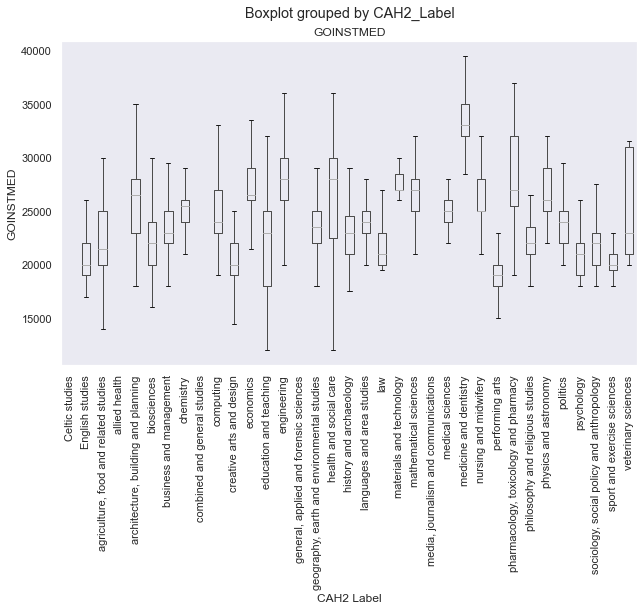

In [26]:
import matplotlib.pyplot as plt

# Group the data by 'CAH2_Label' and create the boxplot
bp = filtered_m_df2.boxplot(column='GOINSTMED', by='CAH2_Label', showfliers=False, grid=False, figsize=(10, 6))

# Set the labels
plt.xlabel('CAH2 Label')
plt.ylabel('GOINSTMED')

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [27]:
merged_df['CAH2_Label'] = pd.Categorical(merged_df['CAH2_Label'])

In [29]:
ECON = SAL_INST_NSS[["GOSALSBJ"]]

In [31]:
ECON1 = merged_df[merged_df["CAH2_Code"] == "CAH15-02"]

In [32]:
Inst_Sal = merged_df.groupby('LEGAL_NAME').median().reset_index().sort_values('GOINSTMED', ascending=False)

In [33]:
Inst_Sal.head(50)

,LEGAL_NAME,GOINSTLQ,GOINSTMED,GOINSTUQ,PUBUKPRN,Q1,Q2,Q3,Q4,Q5,...,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27
245,University College of Estate Management,34000.0,40000.0,50000.0,10008173.0,82.0,64.0,91.0,90.0,83.0,...,78.0,78.0,82.0,48.0,30.0,87.0,64.0,51.0,50.0,86.0
99,Hull York Medical School,30000.0,35000.0,38000.0,99999998.0,69.0,78.0,91.0,75.0,67.0,...,75.0,81.0,87.0,63.0,84.0,75.0,43.0,31.0,34.0,65.0
23,Birkbeck College,24000.0,35000.0,42000.0,10007760.0,80.0,77.0,90.0,82.0,82.0,...,75.0,87.0,80.0,48.0,66.0,82.0,69.0,51.0,44.0,82.0
102,"Imperial College of Science, Technology and Me...",30000.0,33000.0,41500.0,10007154.0,88.0,79.0,90.0,80.5,82.0,...,84.0,85.0,90.0,65.0,85.0,85.0,68.0,46.0,52.0,80.0
204,The London Institute of Banking & Finance,28000.0,32000.0,37500.0,10008289.0,76.0,68.0,64.0,44.0,68.0,...,60.0,75.0,63.0,46.0,56.0,63.0,38.0,29.0,38.0,61.0
38,Brighton and Sussex Medical School,28000.0,32000.0,36000.0,99999999.0,87.0,86.0,94.0,82.0,83.0,...,81.0,89.0,83.0,74.0,85.0,87.0,63.0,60.0,55.0,81.0
205,The London School of Economics and Political S...,25000.0,31500.0,45000.0,10004063.0,87.0,79.0,89.0,79.0,82.0,...,81.0,83.0,91.0,55.0,66.0,83.0,67.0,50.0,57.0,82.0
6,Aecc University College,27000.0,30000.0,40000.0,10000163.0,68.0,61.0,84.0,60.0,51.0,...,70.0,77.0,68.0,65.0,89.0,68.0,29.0,25.0,55.0,43.0
211,The University of Bath,27500.0,30000.0,33000.0,10007850.0,90.0,81.0,89.0,79.0,82.0,...,86.0,88.0,92.0,70.0,90.0,85.0,73.0,56.0,51.5,89.0
207,The Open University,24000.0,30000.0,39000.0,10007773.0,84.0,79.0,90.0,83.0,85.0,...,83.0,83.0,86.0,49.0,58.0,70.0,61.0,38.0,41.0,86.0


In [34]:
top_10 = Inst_Sal.head(10)
bottom_10 = Inst_Sal.tail(10)

combined_df = pd.concat([top_10, bottom_10])

In [35]:
cdf =combined_df[['LEGAL_NAME', 'GOINSTLQ', 'GOINSTMED', 'GOINSTUQ']]

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.robust.robust_linear_model import RLM
from tabulate import tabulate


# One-hot encoding
encoder = OneHotEncoder()
encoder.fit(merged_df[['LEGAL_NAME']])
one_hot_encoded = encoder.transform(merged_df[['LEGAL_NAME']]).toarray()
encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names(['LEGAL_NAME']))
merged_df2 = pd.concat([merged_df, encoded_df], axis=1)

# Read LOCA and Tariff data
LOCA = pd.read_csv('/Users/student/Documents/GitHub/Higher-Education-Analysis/Data/LOCATION.csv')
Tariff = pd.read_csv('/Users/student/Documents/GitHub/Higher-Education-Analysis/Data/TARIFF.csv')

# Preprocess LOCA dataframe
LOCA.drop(columns=['ACCOMURL', 'ACCOMURLW', 'LOCNAMEW', 'SUURL', 'SUURLW'], inplace=True)

# Preprocess Tariff dataframe
nan_count = Tariff[['T001', 'T048', 'T096', 'T112', 'T128', 'T144', 'T160', 'T176', 'T192', 'T208', 'T224']].isna().sum(axis=1)
nan_percent = nan_count / 11
over_half_nan = nan_percent > 0.5
Tariff2 = Tariff[~over_half_nan]

# Merge and preprocess Reg dataframe
Regdf = merged_df[['KISCOURSEID', 'GOINSTMED']]
reg_tar = Tariff2[['KISCOURSEID']]



As we can see that there is no significant correlation using the top and bottom groups, I will transfer the columns into 5 different variables, very low, low, mid, high and very high tariff scores. For reference:
A*	56
A	48
B	40
C	32
D	24
E	16
So to get into the top category, an individual requires more the 4 A* A levels
Most universities seem to accept that 112 UCAS points are the standard for the average UK student. Many different universities assess their candidates on many different factors as part of their criteria and the tariff point requirements give them much flexibility to do so.

In [46]:
tar_med_2 = tar_med2.reset_index()
AV_Points = tar_med_2[['PUBUKPRN', 'AV_POINTS']]
PUB_m_df = merged_df.groupby('PUBUKPRN').median().reset_index()
PUB_m_df
Reg4 = pd.merge(PUB_m_df, AV_Points, on='PUBUKPRN', how='inner')

NameError: name 'tar_med2' is not defined

In [44]:
corr_matrix3 = Reg4.corr()
print(corr_matrix3)

NameError: name 'Reg4' is not defined

In [48]:
Reg4.sort_values('AV_POINTS').head(20)

NameError: name 'Reg4' is not defined

In [49]:
outliers = [10007760, 10005967, 10005451, 10004721, 10003239]

# Get the index of the rows where PUBUKPRN is in the list of outliers
outlier_index = Reg4[Reg4['PUBUKPRN'].isin(outliers)].index

# Drop the rows where PUBUKPRN is in the list of outliers
Reg4 = Reg4.drop(outlier_index)


NameError: name 'Reg4' is not defined

In [ ]:
#outliers to remove 10007760, 10005967, 10005451, 10004721, 10003239

In [50]:
sns.regplot(x='AV_POINTS', y='GOINSTMED', data=Reg4)
plt.show()


NameError: name 'Reg4' is not defined

In [51]:
sns.regplot(x='AV_POINTS', y='GOINSTMED', data=Reg4)
plt.xlabel('Average UCAS points achieved by student')
plt.ylabel('Median wage 15 months after graduating')
plt.show()


NameError: name 'Reg4' is not defined

In [52]:
from sklearn.linear_model import LinearRegression

# Assign the feature columns to X
X = Reg4[['AV_POINTS']]

# Assign the median pay column to y
y = Reg4['GOINSTMED']

# Create an instance of the LinearRegression model
reg = LinearRegression()

# Fit the model using the feature and target data
reg.fit(X, y)

NameError: name 'Reg4' is not defined

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression

# Create a bar chart of the data
plt.bar(summed_data2.index, summed_data2.values)

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Summed Values')
plt.title('Summed Values of Columns')

# Show the plot
plt.show()

# Create new columns for the categories
Tariff2['Low'] = Tariff2[['T001', 'T048', 'T064', 'T080']].sum(axis=1)
Tariff2['Average'] = Tariff2[['T096', 'T112', 'T128']].sum(axis=1)
Tariff2['High'] = Tariff2[['T144', 'T160', 'T176']].sum(axis=1)
Tariff2['Very_High'] = Tariff2[['T192', 'T208', 'T224', 'T240']].sum(axis=1)

reg_tar2 = Tariff2[['PUBUKPRN', 'KISCOURSEID', 'Low', 'Average', 'High', 'Very_High']]
PUB_reg_tar2 = reg_tar2.groupby('PUBUKPRN').median().reset_index()
PUB_m_df = merged_df.groupby('PUBUKPRN').median().reset_index()
PUB_m_df = PUB_m_df[['PUBUKPRN', 'GOINSTMED']]

Reg3 = pd.merge(PUB_m_df, PUB_reg_tar2, on='PUBUKPRN', how='inner')
Reg3 = Reg3.set_index('PUBUKPRN')

# Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(Reg3)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(Reg3)

data_scaled = pd.DataFrame(data_scaled, columns=['GOINSTMED', 'Low', 'Average', 'High', 'Very_High'])
print(data_scaled.corr())

Reg2 = pd.merge(Regdf, reg_tar2, on='KISCOURSEID', how='inner')

# Calculate the correlation matrix and create the heatmap
corr_heat = Reg2[['GOINSTMED', 'Low', 'Average', 'High', 'Very_High']].corr()
sns.heatmap(corr_heat, annot=True, cmap='coolwarm')

# Linear Regression
X = Reg2[['Very_High']]
y = Reg2['GOINSTMED']

reg = LinearRegression()
reg.fit(X, y)

r_squared = reg.score(X, y)
print("R-squared value:", r_squared)


NameError: name 'summed_data2' is not defined

## Creating a filtered DF with only BA and BSC?

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from openpyxl import Workbook
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Loading Data
KS_red = pd.read_excel('/Users/student/Documents/HESA Data/KISCOURSE_reduced1.xlsx')

# Creating filtered DataFrame with only BA and BSC
dfKIS = KS_red[['PUBUKPRN', 'UKPRN', 'KISAIMCODE', 'KISCOURSEID']]
BA_BSC = pd.merge(dfKIS, KIS_AIM, on='KISAIMCODE', how='inner')
BA_BSC = BA_BSC.loc[(BA_BSC['KISAIMCODE'] == 21) | (BA_BSC['KISAIMCODE'] == 0)]

# Calculating average points
columns_to_sum = ['T1', 'T48', 'T64', 'T80', 'T96', 'TN112', 'TN128', 'TN144', 'TN160', 'TN176', 'TN192', 'TN208', 'TN224', 'TN240']
BA_BSC_SAL2 = BA_BSC_SAL2.assign(**{f'T{num}': BA_BSC_SAL2[f'T{num:03}'] * factor for num, factor in [(1, 0.24), (48, 0.55), (64, 0.72), (80, 0.88), (96, 1.04), (112, 1.20), (128, 1.36), (144, 1.52), (160, 1.68), (176, 1.84), (192, 2.00), (208, 2.21), (224, 2.32), (240, 2.70)]})
BA_BSC_SAL2['AV_POINTS'] = BA_BSC_SAL2[columns_to_sum].sum(axis=1)
BA_BSC_SAL2 = BA_BSC_SAL2[['PUBUKPRN_x', 'UKPRN_x', 'KISCOURSEID', 'AV_POINTS']]

# Scatter plot and regression plot
sns.scatterplot(x='AV_POINTS', y='GOINSTMED', data=groupedBA_BSC_SAL3)
sns.regplot(x='AV_POINTS', y='GOINSTMED', data=groupedBA_BSC_SAL3)
plt.xlabel('Average UCAS points achieved by student')
plt.ylabel('Median wage 15 months after graduating')
plt.show()

# Neural Network Model
X = NSS_SAL_C.drop(columns=['GOINSTMED', 'PUBUKPRN_x', 'KISMODE_x', 'KISCOURSEID'])
y = NSS_SAL_C['GOINSTMED']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

# Grid Search for Hyperparameter Tuning
param_grid = {'hidden_layer_sizes': [(100,), (150,), (200,)], 'alpha': [0.0001, 0.001, 0.01], 'solver': ['lbfgs', 'adam']}
neural_net = MLPRegressor(max_iter=1000, verbose=False, random_state=21, tol=0.000000001)
grid_search = GridSearch


NameError: name 'KIS_AIM' is not defined

I have created a reduced version of KISCOURSE outside pandas, as a consequence of the CSV not importing correctly

In [ ]:
five_top_importance=importance_df.head(5)

In [ ]:
# Define the custom values
questions = ['I have received helpful comments on my work', 'The course is intellectually stimulating', 'I have had the right opportunities to work with other students as part of my course', 
             'I have been able to access course-specific resources (e.g. equipment, facilities, software, collections) when I needed to', 'The library resources (e.g. books, online services and learning spaces) have supported my learning well']

# Add the custom_values column to the dataframe
five_top_importance = five_top_importance.assign(questions=questions)

In [ ]:
five_top_importance

In [ ]:
import seaborn as sns

sns.barplot(x='feature', y='importance', hue='questions', dodge=False, data=five_top_importance)
